# **Modern Portfolio Theory - Efficient Frontier**

Benchmark Portfolio

/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_42098/1607233727.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  10 of 10 completed
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_42098/1607233727.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (asset_vol[i], asset_ret[i]),


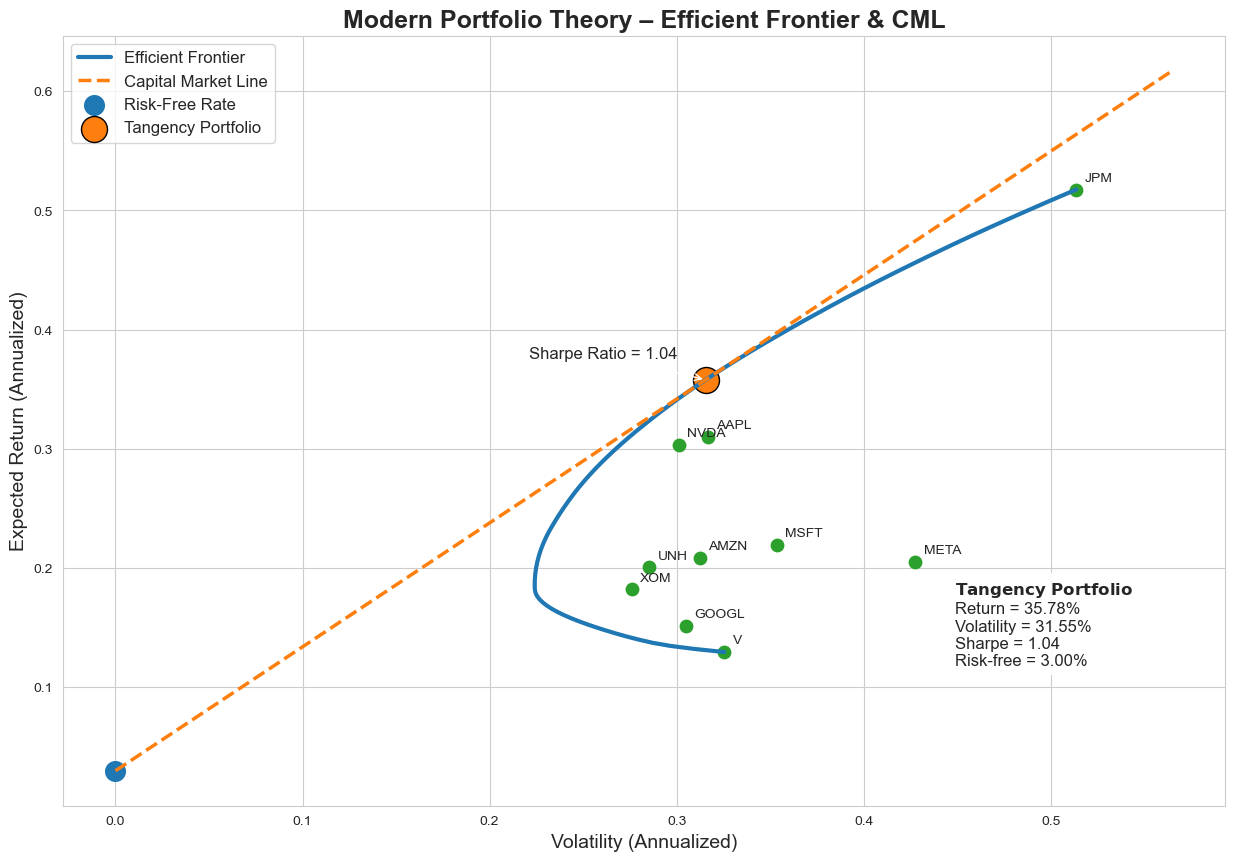

========== TANGENCY PORTFOLIO ==========

Weights:
AAPL: 0.2749
MSFT: 0.0000
AMZN: 0.0000
GOOGL: 0.0000
META: 0.0000
NVDA: 0.2357
JPM: 0.3247
UNH: 0.1647
XOM: 0.0000
V: 0.0000

Performance:
Expected Return: 35.7826%
Volatility: 31.5484%
Sharpe Ratio: 1.0391
Risk-Free Rate: 3.00%


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# -------------------------------------------------
# 1. Parameters
# -------------------------------------------------

stocks = ["AAPL","MSFT","AMZN","GOOGL","META",
          "NVDA","JPM","UNH","XOM","V"]

start_date = "2018-01-01"
end_date = "2024-01-01"
risk_free_rate = 0.03

np.random.seed(42)

# -------------------------------------------------
# 2. Data
# -------------------------------------------------

data = yf.download(stocks, start=start_date, end=end_date)["Close"]
returns = data.pct_change().dropna()

mu = returns.mean() * 252
Sigma = returns.cov() * 252
n = len(stocks)

# -------------------------------------------------
# 3. Portfolio functions
# -------------------------------------------------

def portfolio_performance(weights):
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return ret, vol

def negative_sharpe(weights):
    ret, vol = portfolio_performance(weights)
    return -(ret - risk_free_rate) / vol

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0,1) for _ in range(n))
init_guess = np.ones(n)/n

# -------------------------------------------------
# 4. Tangency portfolio
# -------------------------------------------------

opt = minimize(negative_sharpe, init_guess,
               method='SLSQP',
               bounds=bounds,
               constraints=constraints)

w_opt = opt.x
ret_opt, vol_opt = portfolio_performance(w_opt)
sharpe_opt = (ret_opt - risk_free_rate)/vol_opt

# -------------------------------------------------
# 5. Efficient frontier
# -------------------------------------------------

target_returns = np.linspace(mu.min(), mu.max(), 150)
efficient_vol = []

for target in target_returns:

    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu) - target}
    )

    res = minimize(lambda w: portfolio_performance(w)[1],
                   init_guess,
                   method='SLSQP',
                   bounds=bounds,
                   constraints=constraints)

    efficient_vol.append(res.fun)

efficient_vol = np.array(efficient_vol)

# -------------------------------------------------
# 6. CML
# -------------------------------------------------

cml_x = np.linspace(0, efficient_vol.max()*1.1, 100)
cml_y = risk_free_rate + sharpe_opt * cml_x

# -------------------------------------------------
# 7. Plot
# -------------------------------------------------

sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

# Efficient frontier
plt.plot(efficient_vol, target_returns,
         linewidth=3, label="Efficient Frontier")

# CML
plt.plot(cml_x, cml_y,
         linestyle="--", linewidth=2.5,
         label="Capital Market Line")

# Risk-free rate
plt.scatter(0, risk_free_rate, s=200,
            label="Risk-Free Rate")

# Tangency portfolio
plt.scatter(vol_opt, ret_opt,
            s=350, edgecolors='black',
            label="Tangency Portfolio")

# Individual assets
asset_vol = np.sqrt(np.diag(Sigma))
asset_ret = mu
plt.scatter(asset_vol, asset_ret, s=80)

for i, txt in enumerate(stocks):
    plt.annotate(txt, (asset_vol[i], asset_ret[i]),
                 xytext=(6,6),
                 textcoords='offset points')

# ----- Metrics annotations -----

plt.annotate(f"Sharpe Ratio = {sharpe_opt:.2f}",
             xy=(vol_opt, ret_opt),
             xytext=(vol_opt*0.7, ret_opt*1.05),
             arrowprops=dict(arrowstyle="->"),
             fontsize=12)

# Box with metrics
textstr = '\n'.join((
    r'$\bf{Tangency\ Portfolio}$',
    f'Return = {ret_opt:.2%}',
    f'Volatility = {vol_opt:.2%}',
    f'Sharpe = {sharpe_opt:.2f}',
    f'Risk-free = {risk_free_rate:.2%}'
))

plt.gcf().text(0.72, 0.25, textstr,
               fontsize=12,
               bbox=dict(facecolor='white', alpha=0.9))

plt.title("Modern Portfolio Theory – Efficient Frontier & CML",
          fontsize=18, fontweight='bold')

plt.xlabel("Volatility (Annualized)", fontsize=14)
plt.ylabel("Expected Return (Annualized)", fontsize=14)

plt.legend(fontsize=12)
plt.show()

# -------------------------------------------------
# 8. Print full metrics
# -------------------------------------------------

print("========== TANGENCY PORTFOLIO ==========")
print("\nWeights:")
for i in range(n):
    print(f"{stocks[i]}: {w_opt[i]:.4f}")

print("\nPerformance:")
print(f"Expected Return: {ret_opt:.4%}")
print(f"Volatility: {vol_opt:.4%}")
print(f"Sharpe Ratio: {sharpe_opt:.4f}")
print(f"Risk-Free Rate: {risk_free_rate:.2%}")